# Análise de um grafo de amizades com a base de dados da Yelp para os usuários da cidade de Madison.
Autor: Heitor Lourenço Werneck

- O grafo é não direcionado
- Análise da localização dos vértices

Fonte: https://www.yelp.com/dataset/challenge

In [1]:
import networkx as nx
import numpy as np
import shortestpath
import pandas as pd
import matplotlib.pyplot as plt
def string_to_array(string):
    if string == '':
        return list()
    return eval(string)

In [2]:
users_id=pd.read_csv("~/recsys/data/checkin/madison.csv",usecols=['user_id']).drop_duplicates()['user_id'].to_list()

In [3]:
chunks=pd.read_csv("~/recsys/data/user.csv", chunksize=10 ** 5,converters={'friends':string_to_array})

df_user=pd.read_csv("~/recsys/data/user.csv", nrows=0)

for df_chunk in chunks:
    common=df_chunk[df_chunk.user_id.isin(users_id)]
    print(len(common))
    df_user=df_user.append(common,ignore_index=True)

591
175
154
53
20
18
5
1
3
0
1
0
0
1
0
0
0


In [4]:
len(df_user)

1022

In [5]:
G=nx.Graph()

In [6]:
for index,row in df_user.iterrows():

    G.add_node(row['user_id'])
    for friend_id in row['friends']:
        if friend_id in users_id:
            try:
                G.add_edge(row['user_id'],friend_id)
            except:
                pass

In [7]:
len(G.nodes),len(G.edges)

(1022, 5078)

In [8]:
nx.density(G)

0.009732985005683006

In [9]:
nx.graph_clique_number(G)

17

/usr/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


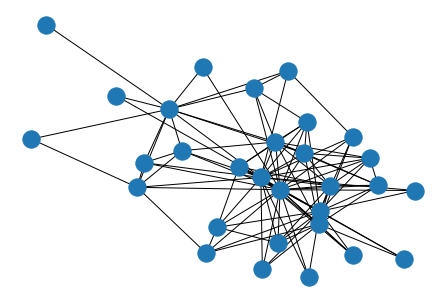

In [10]:
plot= plt.figure()
nx.draw(G.subgraph(list(G.nodes())[0:30]))
plot.savefig("doc/graph.png")

In [11]:
G=nx.to_numpy_matrix(G)

In [12]:
G[G==0]=np.inf

In [13]:
G

matrix([[inf,  1.,  1., ..., inf, inf, inf],
        [ 1., inf, inf, ..., inf, inf, inf],
        [ 1., inf, inf, ..., inf, inf, inf],
        ...,
        [inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf]])

In [14]:
d=shortestpath.floyd_warshall(G)

In [15]:
dcopy= np.squeeze(np.asarray(d))
dcopy

array([[ 2.,  1.,  1., ..., inf, inf, inf],
       [ 1.,  2.,  2., ..., inf, inf, inf],
       [ 1.,  2.,  2., ..., inf, inf, inf],
       ...,
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf]])

In [16]:
dcopy

array([[ 2.,  1.,  1., ..., inf, inf, inf],
       [ 1.,  2.,  2., ..., inf, inf, inf],
       [ 1.,  2.,  2., ..., inf, inf, inf],
       ...,
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf]])

In [17]:
dcopy[dcopy==np.inf],dcopy[dcopy==0]

(array([inf, inf, inf, ..., inf, inf, inf]), array([], dtype=float64))

In [30]:
df_rows=pd.DataFrame(columns=['mean','max','min'])
df_columns=pd.DataFrame(columns=['mean','max','min'])
for i in range(len(dcopy)):
    a=dcopy[i,i+1:]
    b=dcopy[i,:i]
    c=np.concatenate((a,b))
    #print(len(a),len(b),len(c))
    summation=0
    max_value=np.NINF
    min_value=np.inf
    # for in distances
    count=0
    for val in c:
        if val < np.inf:
            max_value=max(max_value,val)
        min_value=min(min_value,val)
        if val < np.inf:
            summation+=val
            count+=1
    
    if max_value==np.NINF:
        max_value=np.inf
    if count==0:
        mean=np.inf
    else:
        try:
            mean = summation/count
        except:
            print("Erro")
    #print(f"summation:{summation}, max_value:{max_value}, min_value:{min_value}, mean:{mean:.2f}")
    df_rows.loc[i]=[mean,max_value,min_value]
    
#     a=dcopy[i+1:,i]
#     b=dcopy[:i,i]
#     c=np.concatenate((a,b))
#     summation=0
#     max_value=np.NINF
#     min_value=np.inf
#     # for in distances
#     for val in c:
#         max_value=max(max_value,val)
#         min_value=min(min_value,val)
#         summation+=val
#     mean = summation/len(c)
#     df_columns.loc[i]=[mean,max_value,min_value]

In [31]:
df_columns.head(5)

,mean,max,min


In [32]:
df_rows.head(5)

,mean,max,min
0,2.263538,4.0,1.0
1,2.093863,4.0,1.0
2,2.280385,4.0,1.0
3,2.038508,4.0,1.0
4,2.291215,4.0,1.0


será utilizado somente um dos dataframes para fazer a análise ja que são equivalentes.

### Explorando distância média

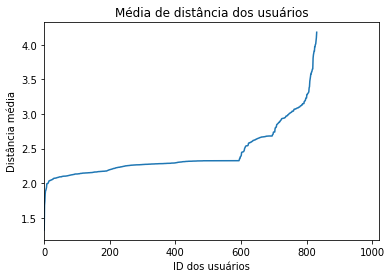

In [42]:
plot=df_rows['mean'].sort_values().reset_index(drop=True).plot()
plot.set_title("Média de distância dos usuários")
plot.set_ylabel("Distância média")
plot.set_xlabel("ID dos usuários")
plot.figure.savefig("doc/pmeandist.png")

In [34]:
df_rows['mean'].describe()

count    1022.000000
mean             inf
std              NaN
min         1.327316
25%         2.255114
50%         2.326113
75%         3.070999
max              inf
Name: mean, dtype: float64

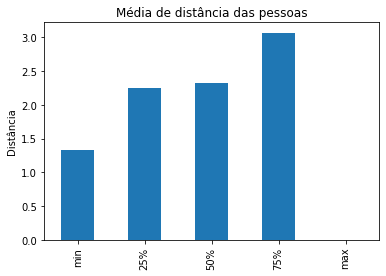

In [45]:
fig = plt.figure()
p=df_rows['mean'].describe().drop(['count','mean','std']).plot.bar(title='Média de distância das pessoas')
p.set_ylabel("Distância")
p
p.figure.savefig("doc/meandist.png")

O gráfico abaixo mostra a relação de percentil ainda mais detalhadamente. Pelo menos 95% das pessoas estão com um valor de distância média maior que 1.41.

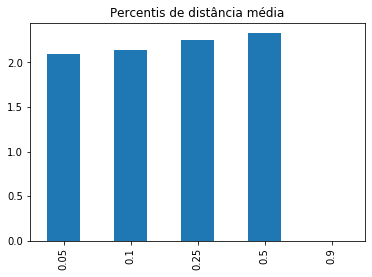

In [36]:
p=df_rows['mean'].sort_values().reset_index(drop=True).quantile([0.05,0.10, 0.25, 0.5, 0.9]).plot.bar(title="Percentis de distância média")
p.figure.savefig("percdist.png")

In [37]:
df_rows['mean'].sort_values().reset_index(drop=True).quantile([0.05, 0.25, 0.5, 0.9])

0.05    2.093863
0.25    2.255114
0.50    2.326113
0.90         inf
Name: mean, dtype: float64

### Explorando distância máxima

O gráfico abaixo mostra que aproximadamente 60% dos usuários tem uma distância máxima de 2 e o resto dos usuários tem uma distância máxima de 3.

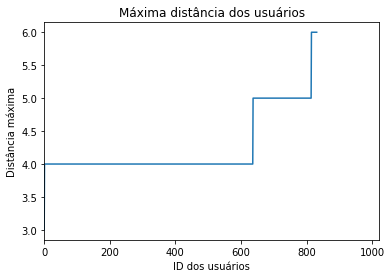

In [46]:
plot=df_rows['max'].sort_values().reset_index(drop=True).plot()
plot.set_title("Máxima distância dos usuários")
plot.set_ylabel("Distância máxima")
plot.set_xlabel("ID dos usuários")
plot.figure.savefig("doc/maxdist.png")

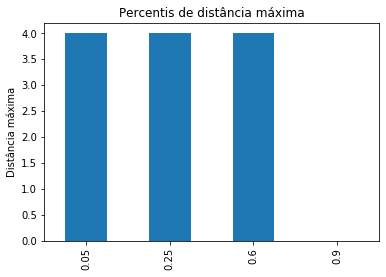

In [39]:
plot=df_rows['max'].sort_values().reset_index(drop=True).quantile([0.05, 0.25, 0.6, 0.9]).plot.bar(title="Percentis de distância máxima")
plot.set_ylabel("Distância máxima")
plot.figure.savefig("percmaxdist.png")

### Explorando distância mínima

Como pode-se ver a distância mínima para todos usuários é 1, isso mostra que todos eles tem uma amizade pelo menos.

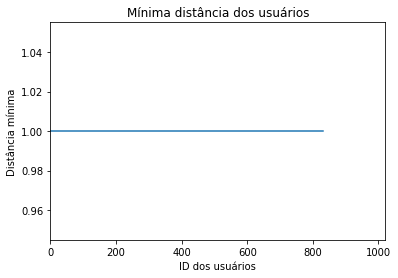

In [40]:
plot=df_rows['min'].sort_values().reset_index(drop=True).plot()
plot.set_title("Mínima distância dos usuários")
plot.set_ylabel("Distância mínima")
plot.set_xlabel("ID dos usuários")
plot.figure.savefig("min.png")

In [57]:
tmp=df_rows['min'].sort_values().reset_index(drop=True)<np.inf
len(tmp[tmp==True]),len(tmp[tmp==False]),len(tmp[tmp==True])/len(tmp)

(832, 190, 0.8140900195694716)